# VELOCITY MODEL CREATION 
To the specifications defined by Bing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import pyfrac
from pyfrac.utils.sofiutils import *
from pyfrac.utils.modellingutils import *
from pyfrac.hydrafrac.acquisition import recgeom

In [ ]:
model_outpath = '/home/birniece/Documents/Projects/HydraFrac/StyloliteEFDModelling/VelocityModels'

In [ ]:
# 'FAKE' Shaheen Paths 
shaheen_proj_loc = '/scratch/birniece/SOFI_StylolitesRockBlock/500umTest'

rec_file = os.path.join(shaheen_proj_loc,'inputs/UtahFORGE_griddedrecs.dat')
model_dir = os.path.join(shaheen_proj_loc,'inputs/model/UtahFORGE_CroppedCentralVolume_5m')
sofi_src_dir = os.path.join(shaheen_proj_loc,'inputs/sources')

sofimaster = '/project/k1056/SOFI_FDmodelling/sofi3d/bin/sofi3D'

# Rock Properties - subsurface models

In [3]:
abs_bounds = 30 # boundary points

In [4]:
dx = dy = dz = 0.001  # 1mm
dimlims = 0.4 + 2*(abs_bounds*dx) # 40cm cubed
nx = ny = nz = int(dimlims/dx) 
print(nx)
# dimlims = nx*dx

# Subsurface properties
vp = 5260  # m/s
vs = 3260  # m/s
rho = 2590;  # kg/m3


460


In [5]:
subsurface_properties = [vp, vs, rho]
vp_mod, vs_mod, rho_mod = make_homo_model(dimlims,
                                            dx,
                                            subsurface_properties,
                                            pad=False,
                                            npad=0,
                                            freesurface=False
                                            )

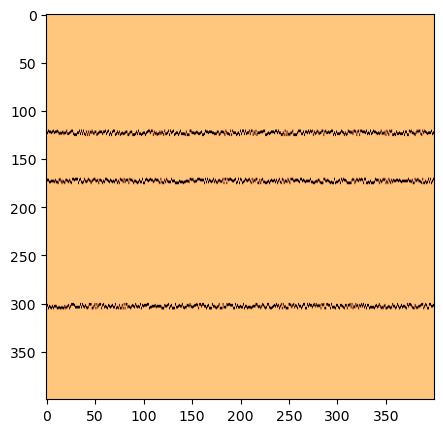

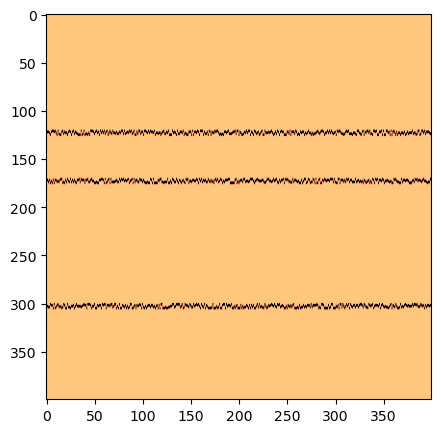

In [6]:
# Add stylolite to model
# Assume crossing z_plane
vp_mod_sty = vp_mod
vs_mod_sty = vs_mod
rho_mod_sty = rho_mod

vp_change = 0.8

sty_jump = 5 # jaggedy-ness of stylolite face
sty_locs = [150, 200, 330]  # 1mm sampling

for xi in range(nx):
    for yi in range(ny):
        for styloc in sty_locs:            
            styz = styloc + np.random.randint(sty_jump)
            vp_mod_sty[xi,styz:styz+3,yi] =  vp*vp_change
            vs_mod_sty[xi,styz:styz+3,yi] =  (vp*vp_change)/1.61
            rho_mod_sty[xi,styz:styz+3,yi] =  1000 * (0.31*(vp*vp_change)**0.25)
#         for styloc in sty_locs:            
#             styz = styloc + np.random.randint(sty_jump)
#             vp_mod_sty[xi,styz:styz+2,yi] =  vp*vp_change
#             vs_mod_sty[xi,styz:styz+2,yi] =  (vp*vp_change)/1.61
#             rho_mod_sty[xi,styz:styz+2,yi] =  1000 * (0.31*(vp*vp_change)**0.25)
#         for styloc in sty_locs:            
#             styz = styloc + np.random.randint(sty_jump)
#             sty_thick = np.random.choice([1,2])
#             vp_mod_sty[xi,styz:styz+sty_thick,yi] =  vp*vp_change
#             vs_mod_sty[xi,styz:styz+sty_thick,yi] =  (vp*vp_change)/1.61
#             rho_mod_sty[xi,styz:styz+sty_thick,yi] =  1000 * (0.31*(vp*vp_change)**0.25)
            
fig,ax = plt.subplots(1,1,figsize=[5,5])
c = ax.imshow(vp_mod_sty[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,0].T, aspect='auto', cmap='copper')
fig,ax = plt.subplots(1,1,figsize=[5,5])
c = ax.imshow(vp_mod_sty[0,abs_bounds:-abs_bounds,abs_bounds:-abs_bounds], cmap='copper')

# Write as binary
os.makedirs(os.path.join(outpath,'inputs/model/'), exist_ok=True)
vp_mod_sty.astype(np.float32).tofile(os.path.join(outpath,'inputs/model/%s.vp'%expname))#,format='<f')
vs_mod_sty.astype(np.float32).tofile(os.path.join(outpath,'inputs/model/%s.vs'%expname))  #,format='<f')
rho_mod_sty.astype(np.float32).tofile(os.path.join(outpath,'inputs/model/%s.rho'%expname))  #,format='<f')

In [7]:
# mod_vp[:,90,:] =  vp*1.25
# mod_vp[:,75,:] =  vp*1.25
# mod_vp[:,65,:] =  vp*1.5
# fig,ax = plt.subplots(1,1,figsize=[5,5])
# c = ax.imshow(mod_vp[nbounds:-nbounds,nbounds:-nbounds,0].T, cmap='copper_r')
# c = ax.imshow(mod_vp[0,nbounds:-nbounds,nbounds:-nbounds].T, cmap='copper_r')

# Acquisition Geometry - Receivers & Source

In [8]:
# Source 
# sx, sy, sz = 0.2, 0.2, 0.2
sx = sy = sz = 0.2 + (abs_bounds*dx)
td = 1e-6  # ignition time
fc = 80000  # central frequency
amp = 1.  # amplitude
string_list = [str(i) for i in [sx, sz, sy, td, fc, amp]]
src_string = '\t'.join(string_list)
print(src_string)

text_file = open(os.path.join(outpath,'inputs/sources.dat'), "wt")
text_file.writelines(src_string)
text_file.close()

0.23	0.23	0.23	1e-06	80000	1.0


In [9]:
# RECEIVERS
nrperface = 5

# don't need to change below
nxyz = [nx-2*abs_bounds, ny-2*abs_bounds, nz-2*abs_bounds]
dxyz = [dx, dy, dz]
gridded_recs, nr, rec_string = recgeom(nxyz, 
                                       dxyz, 
                                       nrperfc_xyz=[nrperface], 
                                       recbuf_gps=10)
print (nr, gridded_recs.shape)
# print(gridded_recs)
gridded_recs = gridded_recs + (abs_bounds*dx)
print(gridded_recs)

np.savetxt(os.path.join(outpath,'inputs/receiver.dat'),
           gridded_recs.T.astype(np.float32), 
           fmt='%.4f')

150 (3, 150)
[[0.031   0.031   0.031   0.031   0.031   0.031   0.031   0.031   0.031
  0.031   0.031   0.031   0.031   0.031   0.031   0.031   0.031   0.031
  0.031   0.031   0.031   0.031   0.031   0.031   0.031   0.43    0.43
  0.43    0.43    0.43    0.43    0.43    0.43    0.43    0.43    0.43
  0.43    0.43    0.43    0.43    0.43    0.43    0.43    0.43    0.43
  0.43    0.43    0.43    0.43    0.43    0.041   0.041   0.041   0.041
  0.041   0.13575 0.13575 0.13575 0.13575 0.13575 0.2305  0.2305  0.2305
  0.2305  0.2305  0.32525 0.32525 0.32525 0.32525 0.32525 0.42    0.42
  0.42    0.42    0.42    0.041   0.041   0.041   0.041   0.041   0.13575
  0.13575 0.13575 0.13575 0.13575 0.2305  0.2305  0.2305  0.2305  0.2305
  0.32525 0.32525 0.32525 0.32525 0.32525 0.42    0.42    0.42    0.42
  0.42    0.041   0.13575 0.2305  0.32525 0.42    0.041   0.13575 0.2305
  0.32525 0.42    0.041   0.13575 0.2305  0.32525 0.42    0.041   0.13575
  0.2305  0.32525 0.42    0.041   0.13575 0.2305 

# BUILD JSON FOR SOFI

In [10]:
# mod params
n_xzy = vp_mod.transpose(0,2,1).shape
d_xzy = [dx, dz, dy]

# time params (in seconds!)
dt = 5e-8
tdur = 0.001
tsnap_params = [dt*10, tdur-(1000*dt), dt*10]
smgrm_ndt = 20

SOFIjsonfilename = os.path.join(outpath,'SOFI3D_%s.json'%expname)

sofimaster = '~/Documents/Projects/MicroseismicModelling/SOFI3D-master/bin/'
num_procs = 8
sofi_param_file = "SOFI3D_%s.json"%expname
shellfilename = os.path.join(outpath,'runSOFI3D_%s.sh'%expname)


In [11]:
# GET THE DIFFERENT STRINGS - this will be updated in the future
default_strs = get_default_strings()

monitor_strs = get_monitor_str(tsnap_params, smgrm_ndt, expname, sbsmp_xyz=10)
t_str = get_time_str(dt, tdur)
mod_strs = get_subsurfmod_str(n_xzy, d_xzy,expname)
bndry_str = get_boundary_str(fs=False, npad=abs_bounds, cpml=False)
src_str = get_source_str()

write_SOFIjsonParams = write_SOFIjsonParams(default_strs, 
                                            monitor_strs,  
                                            t_str, 
                                            mod_strs, 
                                            src_str, 
                                            bndry_str, 
                                            SOFIjsonfilename)
runscript = write_SOFIrunScript(sofimaster, 
                                num_procs, 
                                sofi_param_file, 
                                shellfilename)